(5, 1)


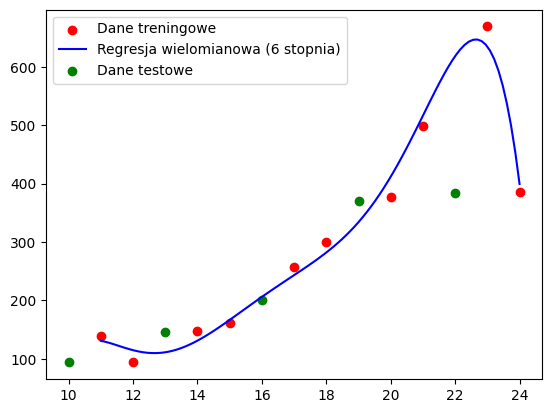

Koszt na zbiorze treningowym: 0.0071
Koszt na zbiorze treningowym: 0.1915


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

def h_fun(X, theta):
    return X @ theta  # Dla macierzy (m, n+1) i (n+1, 1)

def calculate_cost(X, y, theta):
    m = y.shape[0]
    h = h_fun(X, theta)
    return (1 / (2 * m)) * np.sum((h - y) ** 2)

def gradient_descent(X, y, theta, alpha, eps):
    m = y.shape[0]
    previous_cost = float('inf')
    
    while True:
        gradient = (X.T @ (h_fun(X, theta) - y)) / m
        theta = theta - alpha * gradient
        
        current_cost = calculate_cost(X, y, theta)
        if abs(previous_cost - current_cost) < eps:
            break
        previous_cost = current_cost
    
    return theta

# Wczytanie danych
with open("./lin_reg_training.csv", 'r') as f:
    csvreader = csv.reader(f, delimiter=',')
    data = [row for row in csvreader]
    data = np.array(data, dtype=np.float32)

x_train = data[:, 0].reshape(-1, 1)
y_train = data[:, 1].reshape(-1, 1)

with open("./lin_reg_test.csv", 'r') as f:
    csvreader = csv.reader(f, delimiter=',')
    data = [row for row in csvreader]
    data = np.array(data, dtype=np.float32)

x_test = data[:, 0].reshape(-1, 1)
y_test = data[:, 1].reshape(-1, 1) # zmieniamy wektor (n, ) na (n, 1)
print(x_test.shape)

# Standaryzacja
scaler_X = StandardScaler()
scaler_y = StandardScaler()

x_train_scaled = scaler_X.fit_transform(x_train)
y_train_scaled = scaler_y.fit_transform(y_train)
#fit_transform 
#Dane są skalowane, aby miały średnią 0 i odchylenie 1.

#rozszrzenie dostępu cech kombinacji nieliniowej 
poly = PolynomialFeatures(degree=6)
x_train_poly = poly.fit_transform(x_train_scaled)
#dla kazdej wartosci x w x_train_scaled tworzy nowe cechy 
#[1, x^1 ... x^6]

x_test_scaled = scaler_X.transform(x_test)
y_test_scaled = scaler_y.transform(y_test)
x_test_poly = poly.transform(x_test_scaled)
# Inicjalizacja theta
theta = np.zeros((x_train_poly.shape[1], 1))

# Uczenie modelu
theta = gradient_descent(x_train_poly, y_train_scaled, theta, alpha=0.001, eps=1e-7)



#fit_transform liczyłby nową średnią i odchylenie na x_test, co jest błędne 
# – testowanie powinno być na tej samej skali co trening.




x_plot = np.linspace(x_train.min(), x_train.max(), 100).reshape(-1, 1)
y_plot = scaler_y.inverse_transform(h_fun(poly.transform(scaler_X.transform(x_plot)), theta))

plt.scatter(x_train, y_train, color='red', label="Dane treningowe")
plt.plot(x_plot, y_plot, color='blue', label="Regresja wielomianowa (6 stopnia)")
plt.scatter(x_test, y_test, color='green', label="Dane testowe")
plt.legend()
plt.show()



# Ocena modelu na danych treningowych
koszt_train = calculate_cost(x_train_poly, y_train_scaled, theta)
print(f"Koszt na zbiorze treningowym: {koszt_train:.4f}")

#ocena modelu na danych testowych
koszt_train = calculate_cost(x_test_poly, y_test_scaled, theta)
print(f"Koszt na zbiorze treningowym: {koszt_train:.4f}")

Wyraźnie widać, że krzywa nie reprezentuje odpowiednio trendu danych.
Moglibyśmy dodać zbiór testowy do zbioru uczącego, wtedy optymalizacja wzięłaby pod uwagę nowe wartości, jednak nie mamy pewności, że nie pominie to kolejnych danych.

Pomocnym narzędziem w tym przypadku jest regularyzacja. Regularyzacja polega na dodaniu do funkcji kosztu kary stanowiącej sume kwadratów wag wektora theta.
W efekcie czego algorytm stara się znależć kompromis między minimalizacja funkcji kosztu a zmniejzeniem wartości wag.(szczególnie dla tych cech wielomianowych wyższego rzędu), które powodują “zawijanie” dopasowanej krzywej.

In [8]:

def gradient_descent(X, y, theta, alpha, eps, lambdaa):
    m = y.shape[0]
    previous_cost = float('inf')
    
    while True:
        gradient = (X.T @ (h_fun(X, theta) - y)) / m
        theta = theta - alpha * gradient
        
        current_cost = calculate_cost(X, y, theta, lambdaa)
        if abs(previous_cost - current_cost) < eps:
            break
        previous_cost = current_cost
    
    return theta

def calculate_cost(X, y, theta, lambda_):
    m = y.shape[0]
    h = h_fun(X, theta)
    lin_reg_cost = (1 / (2 * m)) * np.sum((h - y) ** 2)
    sum_of_thetas= (theta[1:, :]**2).sum()
    return lin_reg_cost + sum_of_thetas*lambda_/(2*m)

Parametr lambda odpowiada za stopień regularyzacji. Proszę zwrócić uwagę, że lambda dążąca do 0 powinna powodowac, że regularyzacjia ma coraz mniejszy wpływ na funkcje kosztu.

Koszt na zbiorze treningowym dla lambda = 10: 0.2450
Koszt na zbiorze testowym dla lambda = 10: 0.2606
Koszt na zbiorze treningowym dla lambda = 1: 0.0922
Koszt na zbiorze testowym dla lambda = 1: 0.1898
Koszt na zbiorze treningowym dla lambda = 0.01: 0.0145
Koszt na zbiorze testowym dla lambda = 0.01: 0.1561
Koszt na zbiorze treningowym dla lambda = 0.001: 0.0135
Koszt na zbiorze testowym dla lambda = 0.001: 0.1550
Koszt na zbiorze treningowym dla lambda = 0.0001: 0.0134
Koszt na zbiorze testowym dla lambda = 0.0001: 0.1549


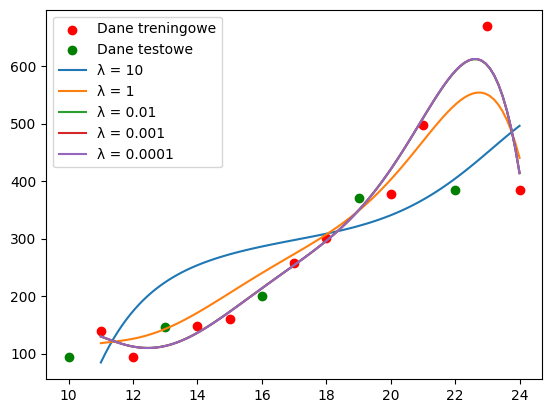

In [9]:
zbior_lambda = [10, 1, 0.01, 0.001, 0.0001]


zbior_lambda = [10, 1, 0.01, 0.001, 0.0001]
wartosc_theta = {}  # Słownik

for lambdaa in zbior_lambda:
    theta = np.zeros((x_train_poly.shape[1], 1))
    theta = gradient_descent(x_train_poly, y_train_scaled, theta, alpha=0.01, eps=1e-5, lambdaa=lambdaa)
    wartosc_theta[lambdaa] = theta 
     # Zapisujemy theta dla każdej wartości lambda w słowniku 

    koszt_train = calculate_cost(x_train_poly, y_train_scaled, theta, lambdaa)
    koszt_test = calculate_cost(x_test_poly, y_test_scaled, theta, lambdaa)

    print(f"Koszt na zbiorze treningowym dla lambda = {lambdaa}: {koszt_train:.4f}")
    print(f"Koszt na zbiorze testowym dla lambda = {lambdaa}: {koszt_test:.4f}")

x_plot = np.linspace(x_train.min(), x_train.max(), 100).reshape(-1, 1)
x_plot_poly = poly.transform(scaler_X.transform(x_plot))

# Rysowanie wykresów dla każdej wartości lambda
plt.scatter(x_train, y_train, color='red', label="Dane treningowe")
plt.scatter(x_test, y_test, color='green', label="Dane testowe")

for lambdaa, theta in wartosc_theta.items(): 
    y_plot = scaler_y.inverse_transform(h_fun(x_plot_poly, theta))
    plt.plot(x_plot, y_plot, label=f"λ = {lambdaa}")

plt.legend()
plt.show()



Regularyzacja dla regresji logistycznej 

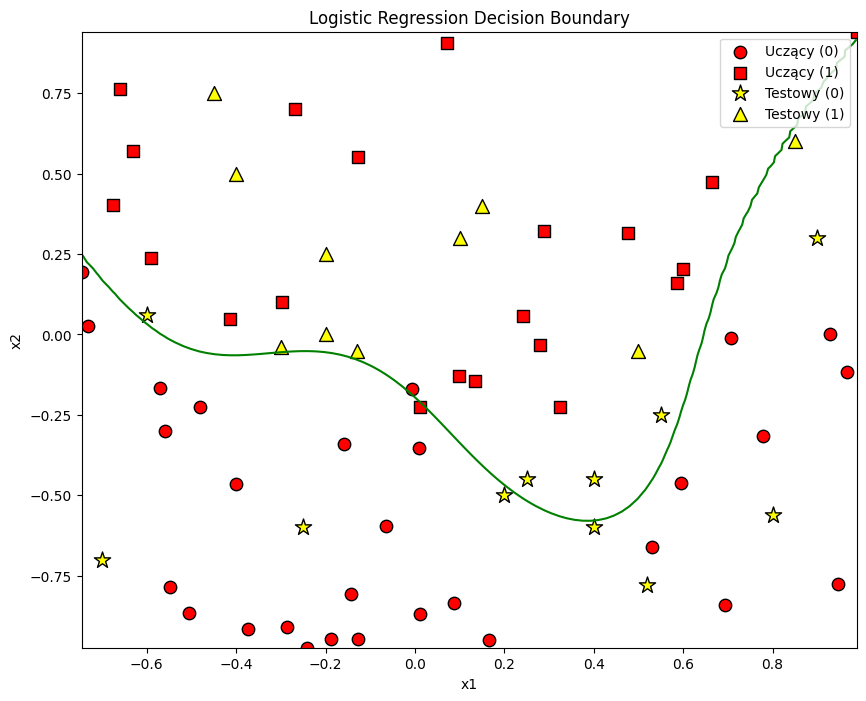

koszt uczenia bez regularyzacji 0.03766125120580306, koszt testu bez regularyzacji 1.2795117154874904


C:\Users\kamil\AppData\Local\Temp\ipykernel_31424\449437401.py:3: RuntimeWarning: overflow encountered in exp
  h = 1.0 / (1.0 + np.exp(-z))
C:\Users\kamil\AppData\Local\Temp\ipykernel_31424\449437401.py:3: RuntimeWarning: overflow encountered in exp
  h = 1.0 / (1.0 + np.exp(-z))
C:\Users\kamil\AppData\Local\Temp\ipykernel_31424\449437401.py:3: RuntimeWarning: overflow encountered in exp
  h = 1.0 / (1.0 + np.exp(-z))


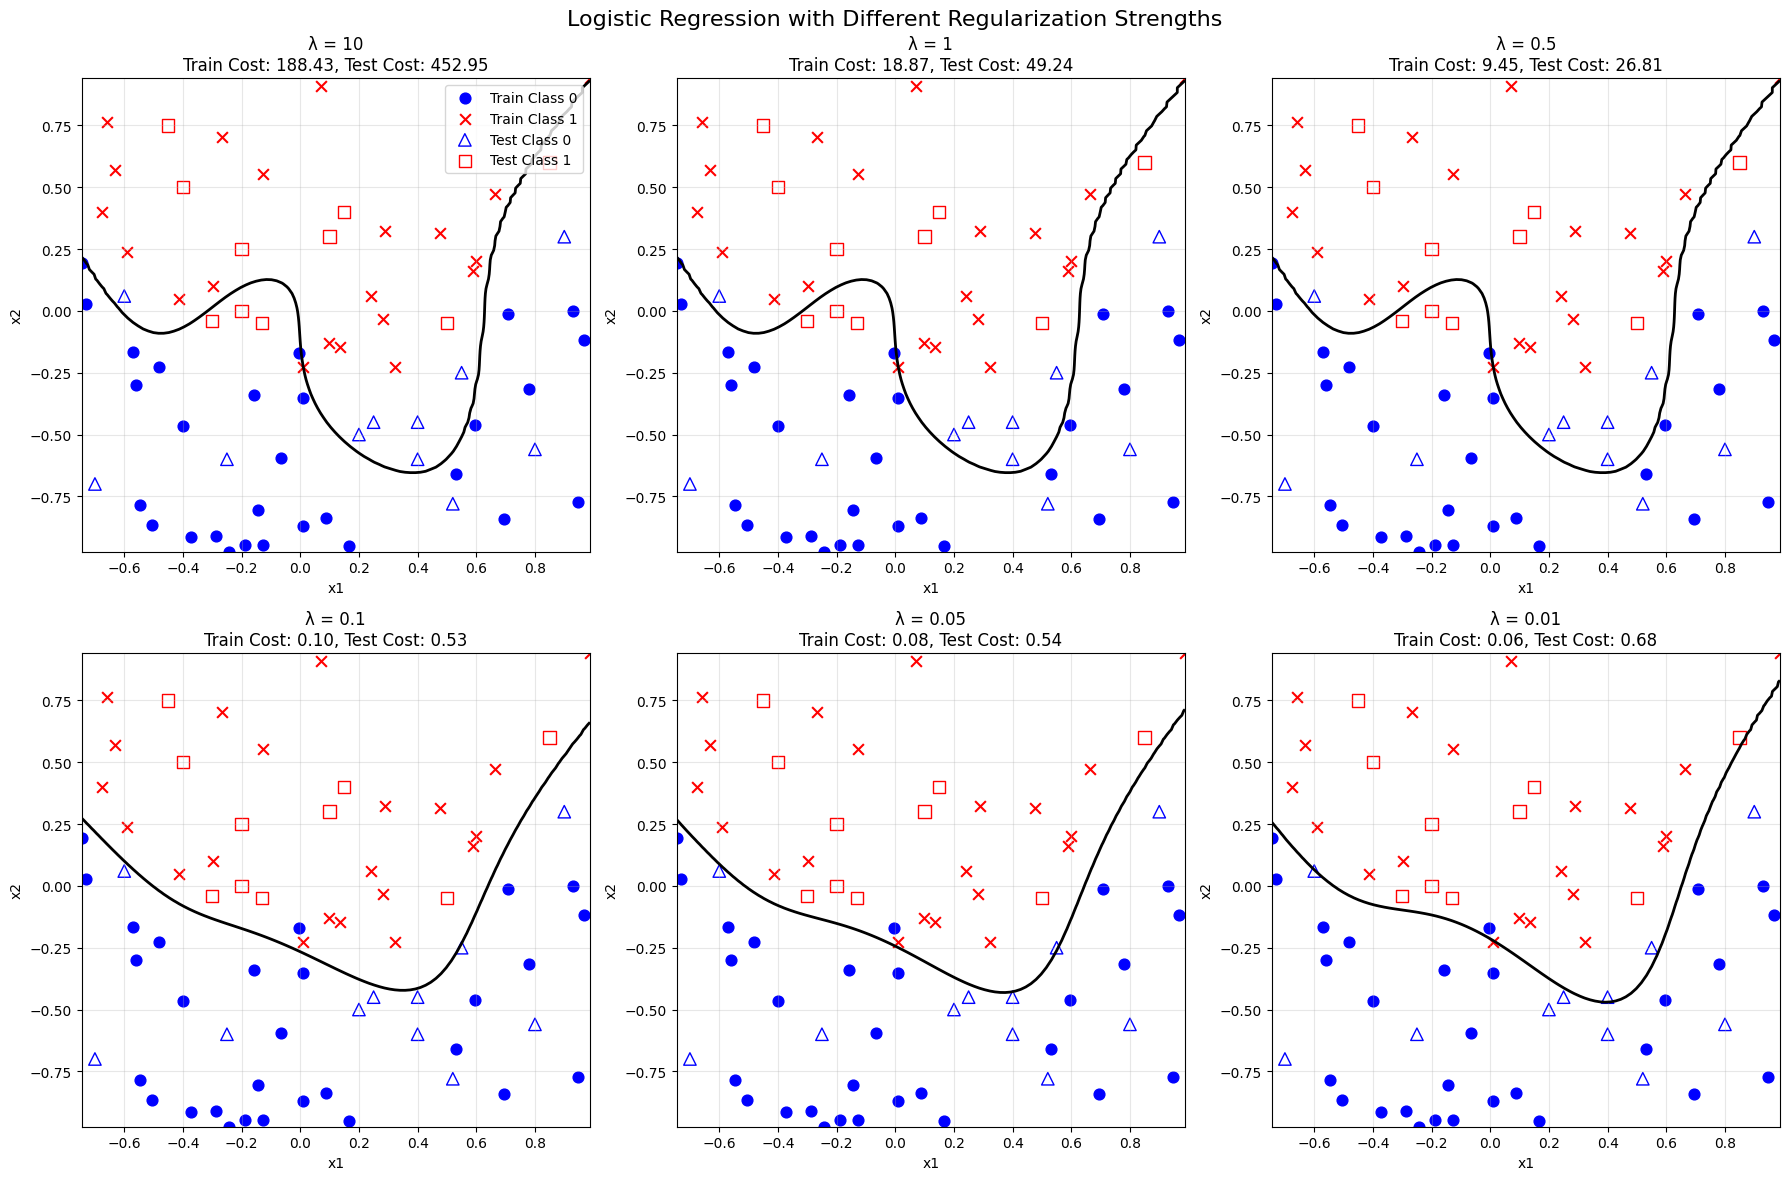

In [10]:



def h_fun(X, theta):
    z = theta.T @ X
    h = 1.0 / (1.0 + np.exp(-z))
    h[h == 0] = 1e-15
    h[h == 1] = 1-1e-15
    return h

def calculate_cost(X, y, theta):
    h = h_fun(X, theta)
    y_1 = -y * np.log(h)
    y_0 = -(1 - y) * np.log(1 - h)
    return (y_1 + y_0).sum() / X.shape[1]

def min_gradient_prosty(X, y, theta, alpha, eps, max_iter) -> tuple[np.array, int]:
    previous_cost = float("inf")
    iter_count = 0  # Licznik iteracji
    
    while iter_count < max_iter:
        h_y_diff = h_fun(X, theta) - y
        gradient = (X @ h_y_diff.T) / y.shape[1]
        theta = theta - alpha * gradient

        current_cost = calculate_cost(X, y, theta)
        if abs(previous_cost - current_cost) < eps:
            break
        
        previous_cost = current_cost
        iter_count += 1

    return theta, iter_count


with open("./logi_reg_training.csv") as f:
    data = np.array([list(map(float, row)) for row in csv.reader(f)])
    y = data[:, 2:3].T #(1, 50)
    x1 = data[:, :1].T
    x2 = data[:, 1:2].T
    X = np.concatenate([np.ones([1, x1.shape[1]]), x1, x2]) # (3, 50)

# Prepare test data (not used in plotting but kept for completeness)
with open("./logi_reg_test.csv") as f:
    data = np.array([list(map(float, row)) for row in csv.reader(f)])
    y_test = data[:, 2:3].T #(1, 50)
    x1_test = data[:, :1].T
    x2_test = data[:, 1:2].T
    X_test = np.concatenate([np.ones([1, x1_test.shape[1]]), x1_test, x2_test]) # (3, 50)


# Standard scaling
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X[1:].T).T  # Scale only x1 and x2, not the bias term
X_scaled = np.concatenate([np.ones([1, X_scaled.shape[1]]), X_scaled])  # Add back bias term

# Polynomial features
poly = PolynomialFeatures(degree=6, include_bias=False)
X_poly = poly.fit_transform(X_scaled[1:].T).T
X_train = np.concatenate([np.ones([1, X_poly.shape[1]]), X_poly])



X_test_scaled = scaler_X.transform(X_test[1:].T).T  # Poprawne skalowanie
X_test_ = poly.transform(X_test[1:].T).T

X_test = np.concatenate([np.ones([1, X_test_.shape[1]]), X_test_])

theta = np.zeros((X_train.shape[0], 1))
alpha = 1e-1  # Współczynnik uczenia
eps = 1e-8

theta, iterations = min_gradient_prosty(X_train, y, theta, alpha, eps, 100000)

# Create grid for plotting
x1_range = np.linspace(X[1].min(), X[1].max(), 100)
x2_range = np.linspace(X[2].min(), X[2].max(), 100)
#od kad do kad i ile wartosci pomiedzy 
#tworzymy wektor zasiegu, dla danych x1, x2
x1x1, x2x2 = np.meshgrid(x1_range, x2_range)
# np.meshgrid tworzy macierz 2D reprezentujacą układ wspólrzednych siatki przestrzeni x1 x2


points = np.c_[x1x1.ravel(), x2x2.ravel()]
#komenda ravel zamienia macierz na jednowymiraowe wektory 
# np.c_ 

points_scaled = scaler_X.transform(points)
#Scaler_X to wczesniej wytrenowany obiekt skalujacy
#transform przeksztalca wartosci cech tak by byly zgodne z wczesnijeszymu danymi wejsciowymi modelu
points_poly = poly.transform(points_scaled)
#tworzymy cechy wielomiany 
X_grid = np.concatenate([np.ones((points_poly.shape[0], 1)), points_poly], axis=1).T
#dodanie kolumny jedynek i trans macierzy 
h_grid = h_fun(X_grid, theta)
h_grid = h_grid.reshape(x1x1.shape)
#przeksztalcenei wynikow do formatu maciezry 2D

# Plotting
plt.figure(figsize=(10, 8))

# Zbiór uczący - klasy 0 i 1
plt.scatter(X[1, y[0]==0], X[2, y[0]==0], 
            color='red', marker='o', s=80, 
            edgecolor='black', label='Uczący (0)')
plt.scatter(X[1, y[0]==1], X[2, y[0]==1], 
            color='red', marker='s', s=80, 
            edgecolor='black', label='Uczący (1)')

# Zbiór testowy - klasy 0 i 1
plt.scatter(X_test[1, y_test[0]==0], X_test[2, y_test[0]==0], 
            color='yellow', marker='*', s=150, 
            edgecolor='black', linewidth=1, label='Testowy (0)')
plt.scatter(X_test[1, y_test[0]==1], X_test[2, y_test[0]==1], 
            color='yellow', marker='^', s=100, 
            edgecolor='black', linewidth=1, label='Testowy (1)')

plt.contour(x1x1, x2x2, h_grid, levels=[0.5], colors='green')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.title('Logistic Regression Decision Boundary')
plt.show()

koszt_testu = calculate_cost(X_test, y_test, theta)  # Nowa linijka do dodania
koszt_uczenia = calculate_cost(X_train, y, theta)

print(f"koszt uczenia bez regularyzacji {koszt_uczenia}, koszt testu bez regularyzacji {koszt_testu}")

def calculate_cost_logi(X, y, theta, lambdaa):
    h = h_fun(X, theta)
    y_1 = -y * np.log(h)
    y_0 = -(1 - y) * np.log(1 - h)
    log_reg_cost=(y_1 + y_0).sum() / X.shape[1]
    sum_of_thetas= (theta[1:, :]**2).sum()
    return log_reg_cost + sum_of_thetas*lambdaa/(2*X.shape[1])


def min_gradient_prosty(X, y, theta, alpha, eps, max_iter, lambdaa) -> tuple[np.array, int]:
    previous_cost = float("inf")
    iter_count = 0  # Licznik iteracji
    
    while iter_count < max_iter:
        h_y_diff = h_fun(X, theta) - y
        gradient = (X @ h_y_diff.T) / y.shape[1]
        theta = theta - alpha * gradient

        current_cost = calculate_cost_logi(X, y, theta, lambdaa)
        if abs(previous_cost - current_cost) < eps:
            break
        
        previous_cost = current_cost
        iter_count += 1

    return theta, iter_count



lambda_values = [10, 1, 0.5, 0.1, 0.05, 0.01]

# Create a figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Logistic Regression with Different Regularization Strengths', fontsize=16)

# Flatten axes for easy iteration
axes = axes.ravel()

for idx, lambda_val in enumerate(lambda_values):
    # Initialize and train model
    theta = np.zeros((X_train.shape[0], 1))
    theta, iterations = min_gradient_prosty(X_train, y, theta, 1e-1, 1e-8, 1000000, lambda_val)
    
    # Create decision boundary grid
    x1_range = np.linspace(X[1].min(), X[1].max(), 100)
    x2_range = np.linspace(X[2].min(), X[2].max(), 100)
    x1x1, x2x2 = np.meshgrid(x1_range, x2_range)
    
    points = np.c_[x1x1.ravel(), x2x2.ravel()]
    points_scaled = scaler_X.transform(points)
    points_poly = poly.transform(points_scaled)
    X_grid = np.concatenate([np.ones((points_poly.shape[0], 1)), points_poly], axis=1).T
    h_grid = h_fun(X_grid, theta).reshape(x1x1.shape)
    
    # Plotting
    ax = axes[idx]
    
    # Training set
    ax.scatter(X[1, y[0]==0], X[2, y[0]==0], 
               color='blue', marker='o', s=60,
               label='Train Class 0' if idx == 0 else "")
    ax.scatter(X[1, y[0]==1], X[2, y[0]==1], 
               color='red', marker='x', s=60,
               label='Train Class 1' if idx == 0 else "")
    
    # Test set
    ax.scatter(X_test[1, y_test[0]==0], X_test[2, y_test[0]==0], 
               color='blue', marker='^', s=80, facecolor='none',
               label='Test Class 0' if idx == 0 else "")
    ax.scatter(X_test[1, y_test[0]==1], X_test[2, y_test[0]==1], 
               color='red', marker='s', s=80, facecolor='none',
               label='Test Class 1' if idx == 0 else "")
    
    # Decision boundary
    ax.contour(x1x1, x2x2, h_grid, levels=[0.5], colors='black', linewidths=2)
    
    # Calculate costs
    train_cost = calculate_cost_logi(X_train, y, theta, lambda_val)
    test_cost = calculate_cost_logi(X_test, y_test, theta, lambda_val)
    
    # Set plot title and labels
    ax.set_title(f'λ = {lambda_val}\nTrain Cost: {train_cost:.2f}, Test Cost: {test_cost:.2f}')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.grid(True, alpha=0.3)
    
    # Add legend only to first subplot
    if idx == 0:
        ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()


Silna regularyzacja → wagi theta (poza biasem θ₀) są mocno karane za bycie duże. Przez co nie dochodzi do over fitingu

C = 10.00 (lambda = 0.10): Train cost = 0.0724, Test cost = 0.5140
C = 1.00 (lambda = 1.00): Train cost = 0.1400, Test cost = 0.5010
C = 0.50 (lambda = 2.00): Train cost = 0.1698, Test cost = 0.5287
C = 0.10 (lambda = 10.00): Train cost = 0.2536, Test cost = 0.6007
C = 0.05 (lambda = 20.00): Train cost = 0.2948, Test cost = 0.6254
C = 0.01 (lambda = 100.00): Train cost = 0.4022, Test cost = 0.6634


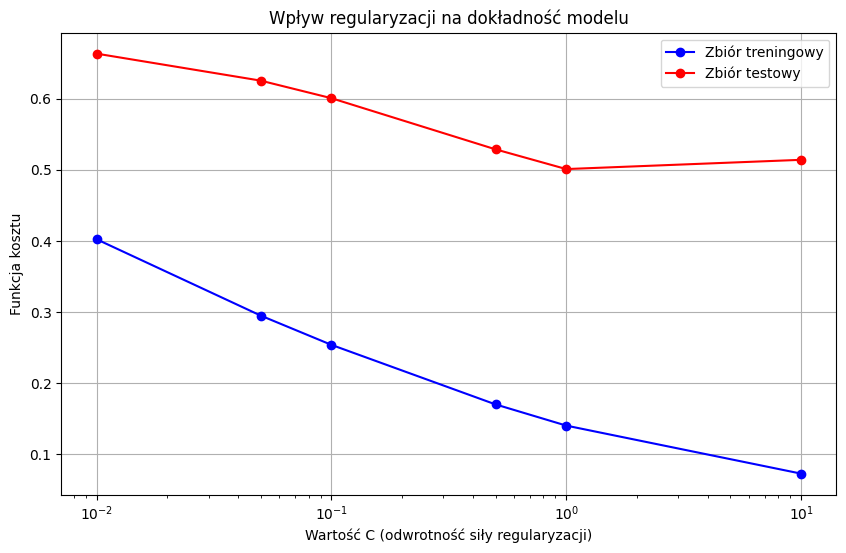

In [ ]:

from sklearn.linear_model import LogisticRegression



# Wczytanie danych - bez zmian
with open("./logi_reg_training.csv") as f:
    data = np.array([list(map(float, row)) for row in csv.reader(f)])
    y = data[:, 2:3].T  # (1, 50)
    x1 = data[:, :1].T
    x2 = data[:, 1:2].T
    X = np.concatenate([np.ones([1, x1.shape[1]]), x1, x2])  # (3, 50)

with open("./logi_reg_test.csv") as f:
    data = np.array([list(map(float, row)) for row in csv.reader(f)])
    y_test = data[:, 2:3].T  # (1, 50)
    x1_test = data[:, :1].T
    x2_test = data[:, 1:2].T
    X_test = np.concatenate([np.ones([1, x1_test.shape[1]]), x1_test, x2_test])  # (3, 50)

# Standaryzacja i cechy wielomianowe - bez zmian
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X[1:].T).T
X_scaled = np.concatenate([np.ones([1, X_scaled.shape[1]]), X_scaled])

poly = PolynomialFeatures(degree=6, include_bias=False)
X_poly = poly.fit_transform(X_scaled[1:].T).T
X_train = np.concatenate([np.ones([1, X_poly.shape[1]]), X_poly])

X_test_scaled = scaler_X.transform(X_test[1:].T).T
X_test_ = poly.transform(X_test[1:].T).T
X_test = np.concatenate([np.ones([1, X_test_.shape[1]]), X_test_])

# Przygotowanie danych dla scikit-learn (tylko zmiana kształtu)
# scikit-learn oczekuje y jako (n_samples,) i X jako (n_samples, n_features)
y_sklearn = y.ravel()  # (50,)
X_sklearn = X_train[1:].T  # (50, 27) - bez jedynek (bias dodaje LogisticRegression automatycznie)

y_test_sklearn = y_test.ravel()  # (50,)
X_test_sklearn = X_test[1:].T  # (50, 27)

# Eksperyment z różnymi wartościami C (odwrotność lambda)
C_values = [10, 1, 0.5, 0.1, 0.05, 0.01]
train_costs = []
test_costs = []

for C in C_values:
    # Inicjalizacja modelu LogisticRegression
    # penalty='l2' - regularyzacja L2 (domyślnie)
    # C - odwrotność lambda (im mniejsze C, tym silniejsza regularyzacja)
    # fit_intercept=False - bo sami dodaliśmy kolumnę jedynek
    model = LogisticRegression(penalty='l2', C=C, max_iter=10000, fit_intercept=False)
    model.fit(X_sklearn, y_sklearn)
    
    # Pobranie wag - theta zawiera też intercept 
    theta = np.concatenate([model.intercept_.reshape(1, 1), model.coef_.T])
    #intercept to wyraz wolny (bias) (1, 1)
    #model.coef pobiera wspolczynnniki wagowe i je transpoonsuje 

    # Obliczenie kosztów (używamy Twojej funkcji calculate_cost)
    train_cost = calculate_cost(X_train, y, theta)
    test_cost = calculate_cost(X_test, y_test, theta)
    
    train_costs.append(train_cost)
    test_costs.append(test_cost)
    
    print(f"C = {C:.2f} (lambda = {1/C:.2f}): Train cost = {train_cost:.4f}, Test cost = {test_cost:.4f}")

# Wykres kosztów
plt.figure(figsize=(10, 6))
plt.plot(C_values, train_costs, 'bo-', label='Zbiór treningowy')
plt.plot(C_values, test_costs, 'ro-', label='Zbiór testowy')
plt.xscale('log')
plt.xlabel('Wartość C (odwrotność siły regularyzacji)')
plt.ylabel('Funkcja kosztu')
plt.title('Wpływ regularyzacji na dokładność modelu')
plt.legend()
plt.grid(True)
plt.show()

# Znalezienie optymalnej wartości C



In [12]:
# Import niezbędnych bibliotek
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, classification_report

# Wczytanie danych
data = load_iris()
x = data.data
y = data.target

# Podział zbioru na treningowy i testowy
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=12345)

# Normalizacja danych
standard_scaler = StandardScaler()
x_train = standard_scaler.fit_transform(x_train)
x_test = standard_scaler.transform(x_test)

# Utworzenie i trenowanie modelu regresji logistycznej bez regularyzacji
log_regr = LogisticRegression(penalty=None, max_iter=1000)  # Zmienione z 'none' na None
log_regr.fit(x_train, y_train)

# Predykcja prawdopodobieństw
y_train_probab = log_regr.predict_proba(x_train)
y_test_probabs = log_regr.predict_proba(x_test)

# Obliczenie funkcji kosztu (log loss)
cost_train = log_loss(y_train, y_train_probab)
cost_test = log_loss(y_test, y_test_probabs)

# Predykcja klas
y_test_pred = log_regr.predict(x_test)

# Wyświetlenie wyników
print(f"Bez regularyzacji, bez cech wielomianowych, koszt na zbiorze uczącym wyniósł: {cost_train}, a na zbiorze testowym: {cost_test}")
print("\nRaport klasyfikacji:\n", classification_report(y_test, y_test_pred))

Bez regularyzacji, bez cech wielomianowych, koszt na zbiorze uczącym wyniósł: 0.0455064566806137, a na zbiorze testowym: 0.041030184250739656

Raport klasyfikacji:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      0.94      0.97        17
           2       0.92      1.00      0.96        12

    accuracy                           0.98        45
   macro avg       0.97      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



In [13]:


# Wczytanie danych
data = load_iris()
x = data.data
y = data.target

# Podział zbioru na treningowy i testowy
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=12345)

# Normalizacja danych
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Dodanie cech wielomianowych (nieliniowość)
poly = PolynomialFeatures(degree=6, include_bias=False)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.transform(x_test)

# Model bez regularyzacji
print("=== Model bez regularyzacji ===")
model_no_reg = LogisticRegression(penalty=None, max_iter=10000)
model_no_reg.fit(x_train_poly, y_train)

# Obliczenie metryk
train_proba = model_no_reg.predict_proba(x_train_poly)
test_proba = model_no_reg.predict_proba(x_test_poly)
y_pred = model_no_reg.predict(x_test_poly)

print(f"Koszt train: {log_loss(y_train, train_proba)}")
print(f"Koszt test: {log_loss(y_test, test_proba)}")
print(classification_report(y_test, y_pred))

# Testowanie różnych regularyzacji
lambdas = [0.001, 0.01, 0.1, 1, 10, 100]
penalties = ['l1', 'l2', 'elasticnet']

best_score = float('inf')
best_params = {}

for penalty in penalties:
    for C in lambdas:  # C = 1/lambda
        # Elasticnet wymaga określenia l1_ratio
        l1_ratio = 0.5 if penalty == 'elasticnet' else None
        
        model = LogisticRegression(penalty=penalty,
                                 C=1/C,
                                 solver='saga' if penalty == 'elasticnet' else 'liblinear',
                                 max_iter=10000,
                                 l1_ratio=l1_ratio)
        model.fit(x_train_poly, y_train)
        
        test_proba = model.predict_proba(x_test_poly)
        current_score = log_loss(y_test, test_proba)
        
        if current_score < best_score:
            best_score = current_score
            best_params = {'penalty': penalty, 'C': C, 'l1_ratio': l1_ratio}
        
        # Dla L2 i lambda=1 (jak w przykładzie)
        if penalty == 'l2' and C == 1:
            print("\n=== Model z regularyzacją L2 (lambda=1) ===")
            y_pred = model.predict(x_test_poly)
            print(f"Koszt train: {log_loss(y_train, model.predict_proba(x_train_poly))}")
            print(f"Koszt test: {current_score}")
            print(classification_report(y_test, y_pred))

# Najlepszy model
print("\n=== Najlepsze parametry ===")
print(f"Znalezione parametry: {best_params}")
best_model = LogisticRegression(penalty=best_params['penalty'],
                              C=1/best_params['C'],
                              solver='saga' if best_params['penalty'] == 'elasticnet' else 'liblinear',
                              max_iter=10000,
                              l1_ratio=best_params['l1_ratio'])
best_model.fit(x_train_poly, y_train)

print(f"Koszt train: {log_loss(y_train, best_model.predict_proba(x_train_poly))}")
print(f"Koszt test: {log_loss(y_test, best_model.predict_proba(x_test_poly))}")
print(classification_report(y_test, best_model.predict(x_test_poly)))

=== Model bez regularyzacji ===
Koszt train: 0.00015351459152773786
Koszt test: 0.4819234652656235
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      0.94      0.97        17
           2       0.92      1.00      0.96        12

    accuracy                           0.98        45
   macro avg       0.97      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45


=== Model z regularyzacją L2 (lambda=1) ===
Koszt train: 0.08579813392994046
Koszt test: 0.1285348234776854
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      0.94      0.97        17
           2       0.92      1.00      0.96        12

    accuracy                           0.98        45
   macro avg       0.97      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45


=== Najlepsze parametry ===
Z